Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [60]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [61]:
## Mounting the google drive :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Changing the directory into required one

In [62]:
cd drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration

[Errno 2] No such file or directory: 'drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration'
/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration


In [63]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path("Test")

In [64]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

Defining some parameters for the loader:

In [65]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [66]:
## Training Train dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [67]:
## Training validaton dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [68]:
# Listing out all the classes of skin cancer and storing them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

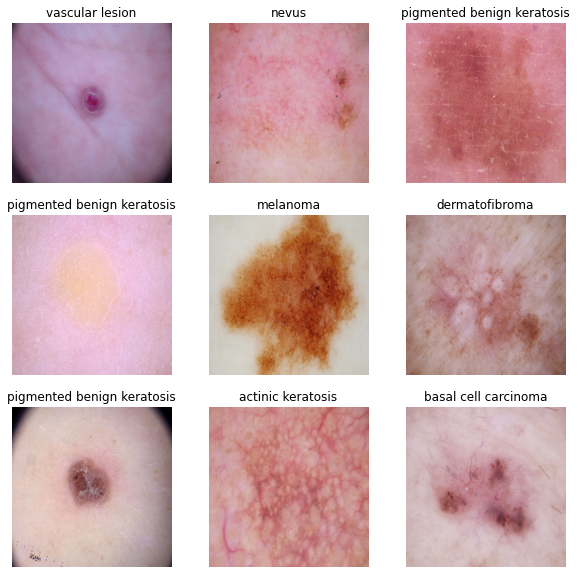

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data to visualize

In [70]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing the data

In [72]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [73]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04074622 1.0


### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [74]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choosing an appropriate optimiser and loss function for model training 

In [75]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
# Viewing the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

### Training the model

In [77]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 92ms/step - loss: 2.2579 - accuracy: 0.2159 - val_loss: 1.8511 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7925 - accuracy: 0.3429 - val_loss: 1.5960 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4901 - accuracy: 0.4610 - val_loss: 1.6110 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4081 - accuracy: 0.4912 - val_loss: 1.4280 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2736 - accuracy: 0.5468 - val_loss: 1.4180 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.1676 - accuracy: 0.5871 - val_loss: 1.4078 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.1039 - accuracy: 0.5997 - val_loss: 1.3801 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing training results

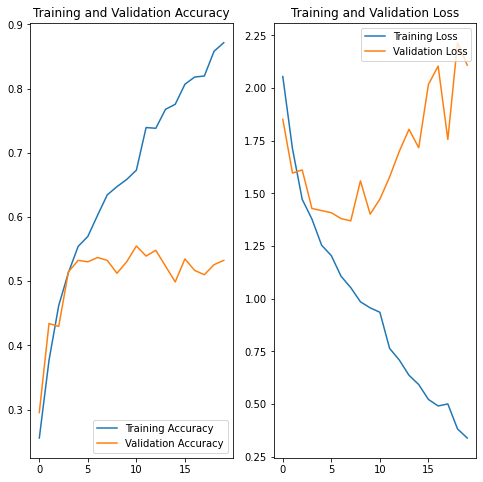

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference from Model 1:

As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

Overfitting: 
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

### Data Augumentation


Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental Keras Preprocessing Layers.

In [79]:
# After I have analysed the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

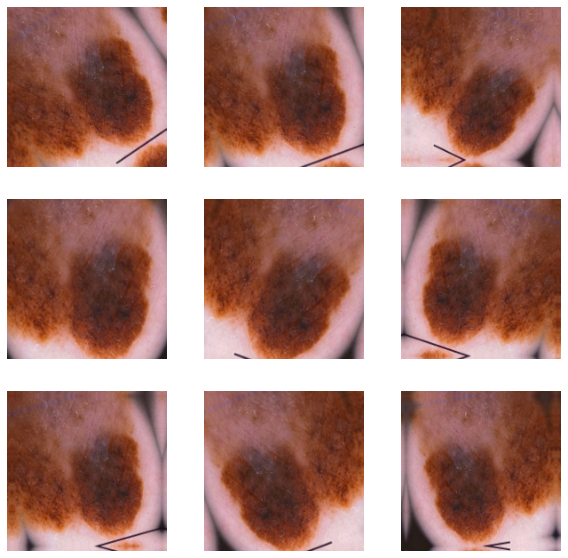

In [80]:
# Visualizing how my augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Creating the model, compiling and training the model


In [81]:
## We are using a  Dropout layer as there is an evidence of overfitting in the above findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [82]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [84]:
## Training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 40ms/step - loss: 2.3442 - accuracy: 0.1878 - val_loss: 1.9239 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.9194 - accuracy: 0.2726 - val_loss: 1.8273 - val_accuracy: 0.3333
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.7193 - accuracy: 0.3793 - val_loss: 1.5864 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5644 - accuracy: 0.4603 - val_loss: 1.5188 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5138 - accuracy: 0.4419 - val_loss: 1.6197 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4161 - accuracy: 0.4967 - val_loss: 1.4349 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3556 - accuracy: 0.5180 - val_loss: 1.3269 - val_accuracy: 0.5391
Epoch 8/20
56

### Visualizing the results

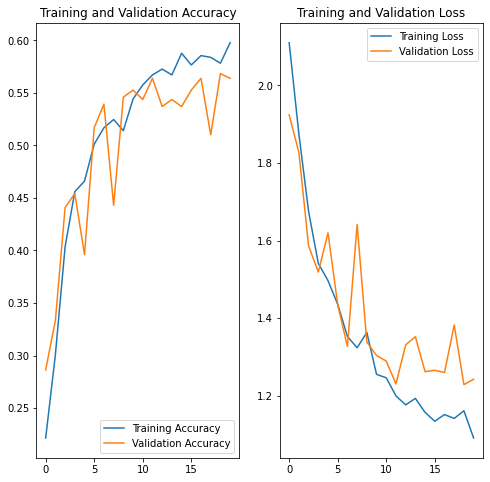

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference from Model 2:

As we can see from the above graphs, the overfitting has been reduced effectively after inclusion of data augumentation and dropout layer.
In the Acc graph, the gap between the training and validation acc has reduced significantly. And in the Loss graph, the gap between the training and validation loss functions have been reduced.
the accuracy has increased to around 60%






#### Finding the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Finding the count of number of jpg's in each class

In [86]:
from pathlib import Path

In [87]:
data_dir_train = pathlib.Path("Train/actinic keratosis")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

Train/actinic keratosis


114

In [88]:
data_dir_train = pathlib.Path("Train/basal cell carcinoma")
print(data_dir_train)
paths2 = Path(data_dir_train).glob('**/*.jpg')
bcc=len(list(paths2))
bcc

Train/basal cell carcinoma


376

In [89]:
data_dir_train = pathlib.Path("Train/dermatofibroma")
print(data_dir_train)
paths3 = Path(data_dir_train).glob('**/*.jpg')
d=len(list(paths3))
d

Train/dermatofibroma


95

In [90]:
data_dir_train = pathlib.Path("Train/melanoma")
print(data_dir_train)
paths4 = Path(data_dir_train).glob('**/*.jpg')
m=len(list(paths4))
m

Train/melanoma


438

In [91]:
data_dir_train = pathlib.Path("Train/nevus")
print(data_dir_train)
paths5 = Path(data_dir_train).glob('**/*.jpg')
n=len(list(paths5))
n

Train/nevus


357

In [92]:
data_dir_train = pathlib.Path("Train/pigmented benign keratosis")
print(data_dir_train)
paths6 = Path(data_dir_train).glob('**/*.jpg')
pbk=len(list(paths6))
pbk

Train/pigmented benign keratosis


462

In [93]:
data_dir_train = pathlib.Path("Train/seborrheic keratosis")
print(data_dir_train)
paths7 = Path(data_dir_train).glob('**/*.jpg')
sk=len(list(paths7))
sk

Train/seborrheic keratosis


77

In [94]:
data_dir_train = pathlib.Path("Train/squamous cell carcinoma")
print(data_dir_train)
paths8 = Path(data_dir_train).glob('**/*.jpg')
scc=len(list(paths8))
scc

Train/squamous cell carcinoma


181

In [95]:

data_dir_train = pathlib.Path("Train/vascular lesion")
print(data_dir_train)
paths9 = Path(data_dir_train).glob('**/*.jpg')
vl=len(list(paths9))
vl

Train/vascular lesion


139

In [96]:
Total=ak+bcc+d+m+n+pbk+sk+scc+vl

In [97]:
hp=int(pbk/Total)
hp

0

#### - Which class has the least number of samples?
## As we can see from the above counts, "seborrheic keratosis" class has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
## From above we can see that the class "pigmented benign keratosis" has the most number of samples.


#### Rectifying the class imbalance
#### Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [98]:
!pip install Augmentor

In [99]:
path_to_training_dataset=os.getcwd()
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [100]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD90A49BC18>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9602ED780>:   0%|          | 1/500 [00:00<01:30,  5.53 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD979760A20>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD90C1EFFD0>: 100%|██████████| 500/500 [00:19<00:00, 26.08 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD960317C88>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD9600B8E10>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD90A49BE10>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD96008D898>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD90A61CAC8>: 100%|██████████| 500/500 [00:41<00:00, 11.97 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD9604D5828>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD90C1AC0B8>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD90A60B7F0>: 100%|██████████| 500/500 [00:19<00:00, 25.73 Samples/s]


In [101]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [102]:
print(data_dir_train)

/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [103]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [104]:
import glob

### Lets see the distribution of augmented data after adding new images to the original training data.

In [105]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025605.jpg_9685296f-0bb1-4d7f-98a2-bad91c770de5.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027615.jpg_e5633391-f982-40de-a330-045d0ec80d1d.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000346.jpg_f871b498-9b49-423b-b449-59c8cd331125.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000230.jpg_11c4a310-e1bb-4e45-817c-726684dd3670.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000498.jpg_ef288555-c0c7-47e5-9235-92368fe163da.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [106]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [107]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [108]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [109]:
# new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [110]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [111]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [112]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model (included normalization)

In [113]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.26421696 0.99117583


In [114]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model

In [115]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

#### Training the model

In [117]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 232ms/step - loss: 2.1461 - accuracy: 0.2036 - val_loss: 1.4758 - val_accuracy: 0.4573
Epoch 2/30
169/169 [==============================] - 41s 234ms/step - loss: 1.3824 - accuracy: 0.4805 - val_loss: 1.2798 - val_accuracy: 0.5345
Epoch 3/30
169/169 [==============================] - 40s 232ms/step - loss: 1.1810 - accuracy: 0.5801 - val_loss: 1.2356 - val_accuracy: 0.5442
Epoch 4/30
169/169 [==============================] - 40s 229ms/step - loss: 1.0042 - accuracy: 0.6364 - val_loss: 1.0360 - val_accuracy: 0.6132
Epoch 5/30
169/169 [==============================] - 40s 229ms/step - loss: 0.8809 - accuracy: 0.6834 - val_loss: 0.9461 - val_accuracy: 0.6867
Epoch 6/30
169/169 [==============================] - 41s 233ms/step - loss: 0.6627 - accuracy: 0.7595 - val_loss: 0.8535 - val_accuracy: 0.7038
Epoch 7/30
169/169 [==============================] - 39s 225ms/step - loss: 0.5268 - accuracy: 0.8083 - val_loss: 0.9582 - val_ac

#### Visualizing the model results

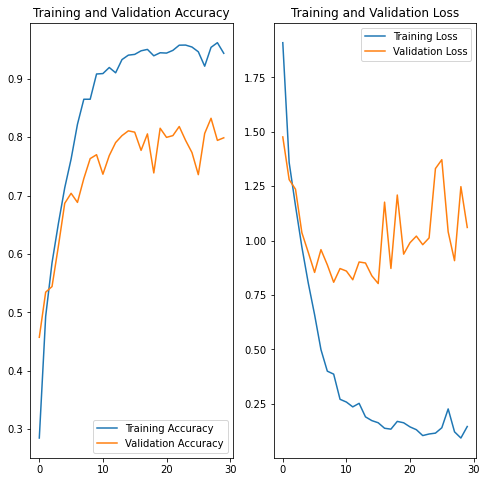

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing the results here. 
We can see here that the training as well as the validation accuracy as well as the Loss has increased in a good amount keeping the gap more or less the same as the previous model. Hence no chance of overfitting.
This model is good to go now.
Here, if more than 30 epochs are used, the results will be better.

